In [5]:
from google.colab import files
uploaded = files.upload()

Saving preprocessing.py to preprocessing.py


In [6]:
from google.colab import files
print("Upload these 4 CSV files:")
print("  1. davidson_english.csv")
print("  2. hasoc_hindi.csv")
print("  3. heot_hinglish.csv")
print("  4. Hinglish_Profanity_List.csv")
uploaded = files.upload()

Upload these 4 CSV files:
  1. davidson_english.csv
  2. hasoc_hindi.csv
  3. heot_hinglish.csv
  4. Hinglish_Profanity_List.csv


Saving davidson_english.csv to davidson_english.csv
Saving hasoc_hindi.csv to hasoc_hindi.csv
Saving heot_hinglish.csv to heot_hinglish.csv
Saving Hinglish_Profanity_List.csv to Hinglish_Profanity_List.csv


In [7]:
import os
print("Files in /content/:")
for f in os.listdir('/content/'):
    if f.endswith('.csv') or f.endswith('.py'):
        print(f"  - {f}")

Files in /content/:
  - davidson_english.csv
  - heot_hinglish.csv
  - hasoc_hindi.csv
  - preprocessing.py
  - Hinglish_Profanity_List.csv


In [8]:
from preprocessing import clean_text, load_datasets, load_profanity_list, count_profanity, get_profanity_score

df = load_datasets(
    '/content/davidson_english.csv',
    '/content/hasoc_hindi.csv',
    '/content/heot_hinglish.csv'
)

profanity_words, profanity_df = load_profanity_list('/content/Hinglish_Profanity_List.csv')

[1/3] Loading English (Davidson)...
   ✓ English: 24783 samples
[2/3] Loading Hindi (HASOC)...
   ✓ Hindi: 9330 samples
[3/3] Loading Hinglish (HEOT)...
   ✓ Hinglish: 3189 samples

Total: 37302 samples
✓ Loaded 220 profanity words


# **Logistic Regression Model**

In [9]:
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("="*60)
print("LOGISTIC REGRESSION MODEL")
print("="*60)

# Add profanity features
df['profanity_count'] = df['text'].apply(lambda x: count_profanity(x, profanity_words))
df['profanity_score'] = df['text'].apply(lambda x: get_profanity_score(x, profanity_df))

print("\nProfanity Analysis:")
print(f"  Non-Hate avg: {df[df['label']==0]['profanity_count'].mean():.3f}")
print(f"  Hate avg:     {df[df['label']==1]['profanity_count'].mean():.3f}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

train_idx = X_train.index
test_idx = X_test.index
prof_train = df.loc[train_idx, ['profanity_count', 'profanity_score']].values
prof_test = df.loc[test_idx, ['profanity_count', 'profanity_score']].values

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

# TF-IDF Vectorization
print("\nVectorizing with TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Combine TF-IDF + Profanity features
X_train_combined = hstack([X_train_tfidf, prof_train])
X_test_combined = hstack([X_test_tfidf, prof_test])

print(f"Features: {X_train_combined.shape[1]} (TF-IDF + Profanity)")

# Train Model
print("\nTraining...")
model = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)
model.fit(X_train_combined, y_train)
print("✓ Training complete!")

# Evaluate
y_pred = model.predict(X_test_combined)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"  Accuracy:  {accuracy*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  Recall:    {recall*100:.2f}%")
print(f"  F1-Score:  {f1*100:.2f}%")
print(f"\nConfusion Matrix:")
print(f"  TN={cm[0][0]}, FP={cm[0][1]}")
print(f"  FN={cm[1][0]}, TP={cm[1][1]}")

LOGISTIC REGRESSION MODEL

Profanity Analysis:
  Non-Hate avg: 0.020
  Hate avg:     0.086

Train: 29841 | Test: 7461

Vectorizing with TF-IDF...
Features: 5002 (TF-IDF + Profanity)

Training...
✓ Training complete!

RESULTS
  Accuracy:  88.47%
  Precision: 97.73%
  Recall:    86.45%
  F1-Score:  91.74%

Confusion Matrix:
  TN=1824, FP=111
  FN=749, TP=4777


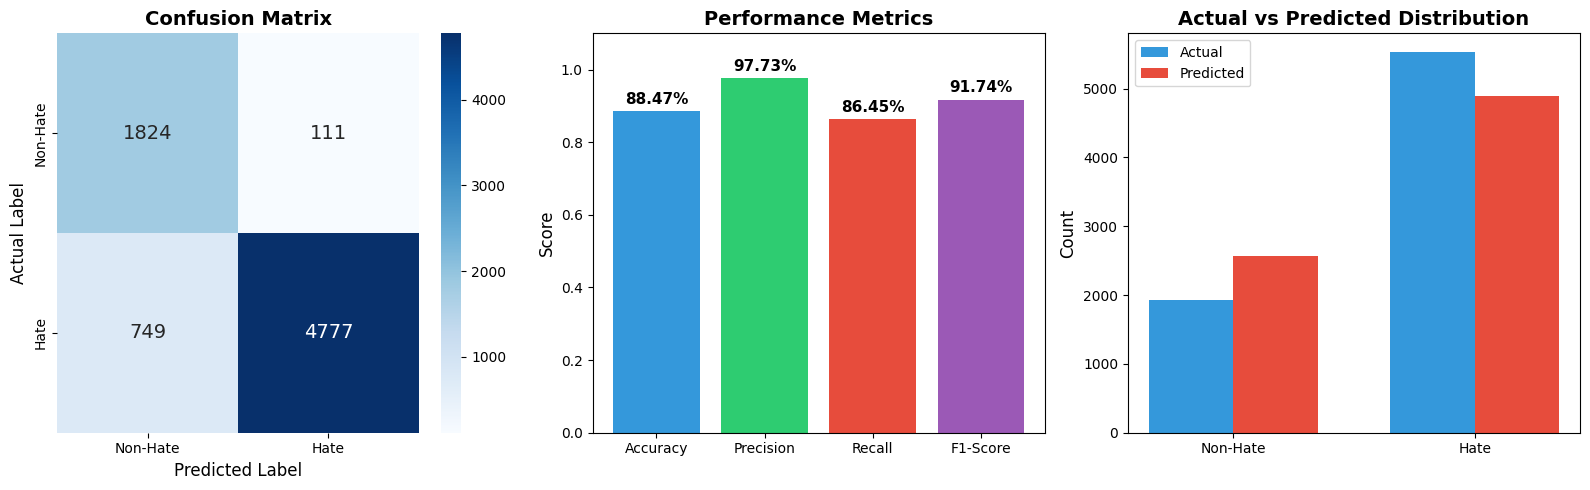

✓ Saved lr_results_detailed.png


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'],
            annot_kws={'size': 14})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('Actual Label', fontsize=12)

# 2. Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12)
for bar, val in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val*100:.2f}%', ha='center', fontsize=11, fontweight='bold')

# 3. Prediction Distribution
pred_counts = pd.Series(y_pred).value_counts().sort_index()
actual_counts = y_test.value_counts().sort_index()
x = np.arange(2)
width = 0.35
axes[2].bar(x - width/2, actual_counts.values, width, label='Actual', color='#3498db')
axes[2].bar(x + width/2, pred_counts.values, width, label='Predicted', color='#e74c3c')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Non-Hate', 'Hate'])
axes[2].set_title('Actual vs Predicted Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].legend()

plt.tight_layout()
plt.savefig('/content/lr_results_detailed.png', dpi=200, bbox_inches='tight')
plt.show()
print("✓ Saved lr_results_detailed.png")

In [29]:
from google.colab import files

results = f"""LOGISTIC REGRESSION RESULTS
{'='*40}

Dataset: {len(df)} samples
  - English:  {len(df[df['language']=='english'])}
  - Hindi:    {len(df[df['language']=='hindi'])}
  - Hinglish: {len(df[df['language']=='hinglish'])}

Features: TF-IDF (5000) + Profanity (2)

Results:
  Accuracy:  {accuracy*100:.2f}%
  Precision: {precision*100:.2f}%
  Recall:    {recall*100:.2f}%
  F1-Score:  {f1*100:.2f}%

Confusion Matrix:
  TN={cm[0][0]}, FP={cm[0][1]}
  FN={cm[1][0]}, TP={cm[1][1]}
"""

with open('/content/lr_results.txt', 'w') as f:
    f.write(results)
files.download('/content/lr_results_detailed.png')
files.download('/content/lr_results.txt')
print("✓ Downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded!


In [11]:
# Check GPU
import torch
if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("✗ No GPU - Go to Runtime → Change runtime type → T4 GPU")
    device = torch.device('cpu')

# Install transformers
!pip install transformers -q
print("✓ Transformers installed")

✓ GPU Available: Tesla T4
✓ Transformers installed


In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Fixed: import from torch.optim
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("✓ All libraries imported")

✓ All libraries imported


In [13]:
import os
print("Files in /content/:")
for f in os.listdir('/content/'):
    if f.endswith('.csv') or f.endswith('.py'):
        print(f"  - {f}")

Files in /content/:
  - davidson_english.csv
  - heot_hinglish.csv
  - hasoc_hindi.csv
  - preprocessing.py
  - Hinglish_Profanity_List.csv


In [14]:
from preprocessing import clean_text, load_datasets

# Reload data
df = load_datasets(
    '/content/davidson_english.csv',
    '/content/hasoc_hindi.csv',
    '/content/heot_hinglish.csv'
)

print(f"\nData ready: {len(df)} samples")

[1/3] Loading English (Davidson)...
   ✓ English: 24783 samples
[2/3] Loading Hindi (HASOC)...
   ✓ Hindi: 9330 samples
[3/3] Loading Hinglish (HEOT)...
   ✓ Hinglish: 3189 samples

Total: 37302 samples

Data ready: 37302 samples


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 29841 | Test: 7461


In [16]:
# Load mBERT tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"✓ Tokenizer loaded: {model_name}")

# Custom Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class created")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

✓ Tokenizer loaded: bert-base-multilingual-cased
✓ Dataset class created


In [17]:
# Create datasets
train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
test_dataset = HateSpeechDataset(X_test, y_test, tokenizer)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

✓ Train batches: 933
✓ Test batches: 234


In [18]:
# Load pre-trained mBERT with classification head
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
model.to(device)

print(f"✓ Model loaded and moved to {device}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded and moved to cuda
  Parameters: 177,854,978


In [19]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"✓ Total training steps: {total_steps}")

✓ Optimizer: AdamW (lr=2e-05)
✓ Total training steps: 2799


In [20]:
print("="*60)
print("TRAINING mBERT")
print("="*60)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS} | Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"\n✓ Epoch {epoch+1}/{EPOCHS} Complete | Avg Loss: {avg_loss:.4f}\n")

print("="*60)
print("✓ TRAINING COMPLETE!")
print("="*60)

TRAINING mBERT
  Epoch 1/3 | Batch 100/933 | Loss: 0.4367
  Epoch 1/3 | Batch 200/933 | Loss: 0.2780
  Epoch 1/3 | Batch 300/933 | Loss: 0.1147
  Epoch 1/3 | Batch 400/933 | Loss: 0.2065
  Epoch 1/3 | Batch 500/933 | Loss: 0.4298
  Epoch 1/3 | Batch 600/933 | Loss: 0.1609
  Epoch 1/3 | Batch 700/933 | Loss: 0.0541
  Epoch 1/3 | Batch 800/933 | Loss: 0.1871
  Epoch 1/3 | Batch 900/933 | Loss: 0.4786

✓ Epoch 1/3 Complete | Avg Loss: 0.2509

  Epoch 2/3 | Batch 100/933 | Loss: 0.0378
  Epoch 2/3 | Batch 200/933 | Loss: 0.1478
  Epoch 2/3 | Batch 300/933 | Loss: 0.1265
  Epoch 2/3 | Batch 400/933 | Loss: 0.1213
  Epoch 2/3 | Batch 500/933 | Loss: 0.1404
  Epoch 2/3 | Batch 600/933 | Loss: 0.2580
  Epoch 2/3 | Batch 700/933 | Loss: 0.0957
  Epoch 2/3 | Batch 800/933 | Loss: 0.0254
  Epoch 2/3 | Batch 900/933 | Loss: 0.1910

✓ Epoch 2/3 Complete | Avg Loss: 0.1493

  Epoch 3/3 | Batch 100/933 | Loss: 0.0110
  Epoch 3/3 | Batch 200/933 | Loss: 0.2619
  Epoch 3/3 | Batch 300/933 | Loss: 0.218

In [21]:
print("\nEvaluating on test set...")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
mbert_accuracy = accuracy_score(all_labels, all_preds)
mbert_precision = precision_score(all_labels, all_preds)
mbert_recall = recall_score(all_labels, all_preds)
mbert_f1 = f1_score(all_labels, all_preds)
mbert_cm = confusion_matrix(all_labels, all_preds)

print(f"\n{'='*60}")
print("mBERT RESULTS")
print(f"{'='*60}")
print(f"  Accuracy:  {mbert_accuracy*100:.2f}%")
print(f"  Precision: {mbert_precision*100:.2f}%")
print(f"  Recall:    {mbert_recall*100:.2f}%")
print(f"  F1-Score:  {mbert_f1*100:.2f}%")
print(f"\nConfusion Matrix:")
print(f"  TN={mbert_cm[0][0]}, FP={mbert_cm[0][1]}")
print(f"  FN={mbert_cm[1][0]}, TP={mbert_cm[1][1]}")


Evaluating on test set...

mBERT RESULTS
  Accuracy:  94.21%
  Precision: 96.12%
  Recall:    96.06%
  F1-Score:  96.09%

Confusion Matrix:
  TN=1721, FP=214
  FN=218, TP=5308


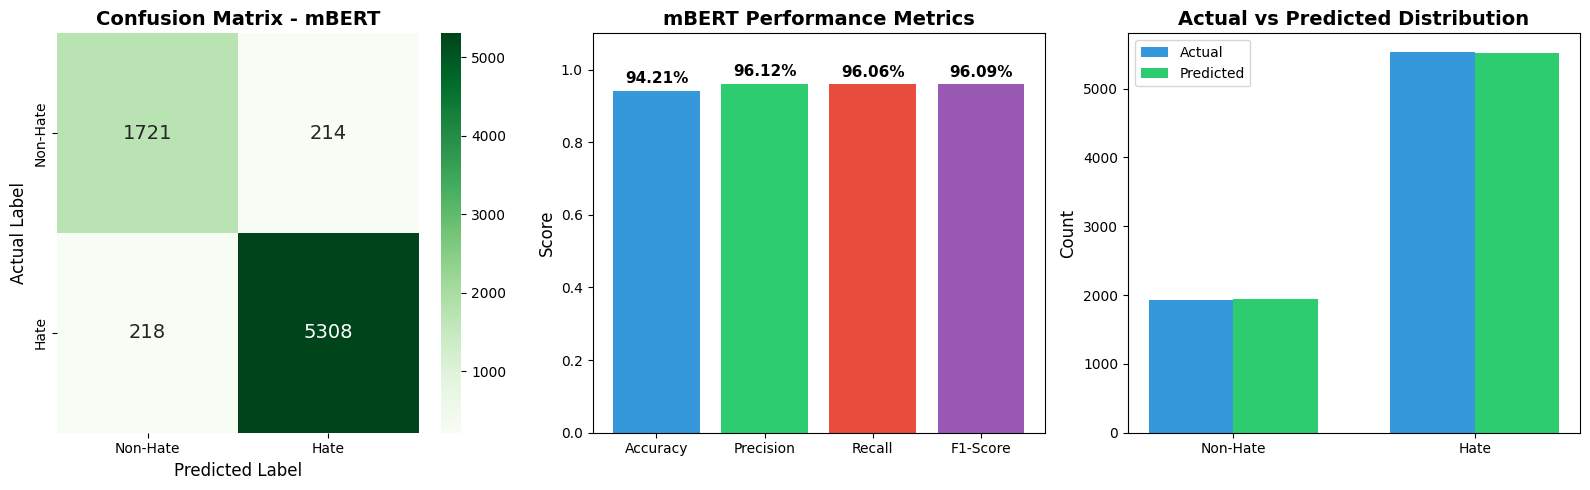

✓ Saved mbert_results.png


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix
sns.heatmap(mbert_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'],
            annot_kws={'size': 14})
axes[0].set_title('Confusion Matrix - mBERT', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('Actual Label', fontsize=12)

# 2. Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [mbert_accuracy, mbert_precision, mbert_recall, mbert_f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1.1)
axes[1].set_title('mBERT Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12)
for bar, val in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val*100:.2f}%', ha='center', fontsize=11, fontweight='bold')

# 3. Prediction Distribution
pred_counts = pd.Series(all_preds).value_counts().sort_index()
actual_counts = pd.Series(all_labels).value_counts().sort_index()
x = np.arange(2)
width = 0.35
axes[2].bar(x - width/2, actual_counts.values, width, label='Actual', color='#3498db')
axes[2].bar(x + width/2, pred_counts.values, width, label='Predicted', color='#2ecc71')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Non-Hate', 'Hate'])
axes[2].set_title('Actual vs Predicted Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].legend()

plt.tight_layout()
plt.savefig('/content/mbert_results.png', dpi=200, bbox_inches='tight')
plt.show()
print("✓ Saved mbert_results.png")

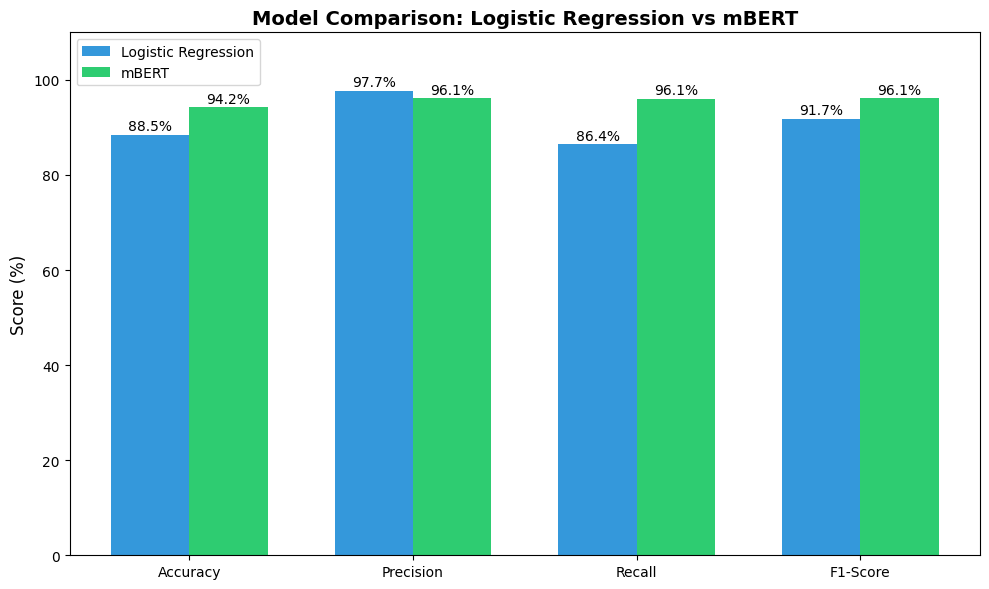

✓ Saved model_comparison.png


In [23]:
# Compare LR vs mBERT
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lr_values = [accuracy, precision, recall, f1]  # From earlier LR results
mbert_values = [mbert_accuracy, mbert_precision, mbert_recall, mbert_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [v*100 for v in lr_values], width, label='Logistic Regression', color='#3498db')
bars2 = ax.bar(x + width/2, [v*100 for v in mbert_values], width, label='mBERT', color='#2ecc71')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Model Comparison: Logistic Regression vs mBERT', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 110)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=200, bbox_inches='tight')
plt.show()
print("✓ Saved model_comparison.png")

In [25]:
from google.colab import files

# Save mBERT results
mbert_results = f"""mBERT RESULTS
{'='*40}

Model: bert-base-multilingual-cased
Epochs: {EPOCHS}
Batch Size: {BATCH_SIZE}
Learning Rate: {LEARNING_RATE}

Dataset: {len(df)} samples
Train: {len(X_train)} | Test: {len(X_test)}

Results:
  Accuracy:  {mbert_accuracy*100:.2f}%
  Precision: {mbert_precision*100:.2f}%
  Recall:    {mbert_recall*100:.2f}%
  F1-Score:  {mbert_f1*100:.2f}%

Confusion Matrix:
  TN={mbert_cm[0][0]}, FP={mbert_cm[0][1]}
  FN={mbert_cm[1][0]}, TP={mbert_cm[1][1]}
"""

with open('/content/mbert_results.txt', 'w') as f:
    f.write(mbert_results)

# Download all
files.download('/content/mbert_results.txt')
files.download('/content/mbert_results.png')
files.download('/content/model_comparison.png')

print("✓ All files downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files downloaded!
